In [8]:
#python imports (i suggest you download anaconda to run this notebook)
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile
from IPython.display import Audio

#Utility function for dB scaling of magnitude spectra
def sig2db(mag_spec):
    return 20*np.log10(mag_spec)

%matplotlib inline

In [6]:
#This is a helper for creating a digital filter
#If your audio is too detailed (high bit representation), you will hear the PWM switching frequency
# This can be filtered out using a digital filter! 

bits_used = input("Please type the number of bits you are using to represent each audio sample: ")
pwm_frequency = 100000000/(2**int(bits_used)) #assuming you are using a 100 MHz clock to drive your pwm logic (which it is default for Urbana Board)
print(f"There will be a {pwm_frequency} Hz component in your final pwm audio output")


There will be a 12207.03125 Hz component in your final pwm audio output


In [25]:
#lets design a digital lowpass filter to get rid of the pwm frequency component
N = 50 #specify the size of the filter (you can make this higher, but it will use more memory)
passBand = [0, 0.28] #this range (multiplied by pi) will pass in all frequencies below the pwm_frequency
stopBand = [(1/np.pi), 1] #this will attenuate all frequencies at or above the pwm_frequency
bands = passBand+stopBand
print(bands)
desired = [100, 0] #the factor you want to multiply the pass band and the stop band

coef = signal.remez(N, bands, desired, fs = 2) # this will be the sequence of values you need to paste in the coefficient field when you...
#...use the FIR compiler

fractionCoef = input("Do you want fractional coefficients (yes or no)?")
boolFrac = 1 if fractionCoef in ("yes", "y", "yes daddy", "Yes", "Y") else 0
print(boolFrac)
with open("filterCoef.txt", "w") as f:
    if boolFrac:
        f.write(", ".join(f"{x:.3f}" for x in coef)) # the .3f signifies 3 decimal point rounding (ex: 2.345, 62.129, 1.000, etc...)
    else:
        f.write(", ".join(f"{int(x)}" for x in coef))
        
#now you can copy the filter coefficients into vivado and create use your digital filter

[0, 0.28, 0.3183098861837907, 1]
1


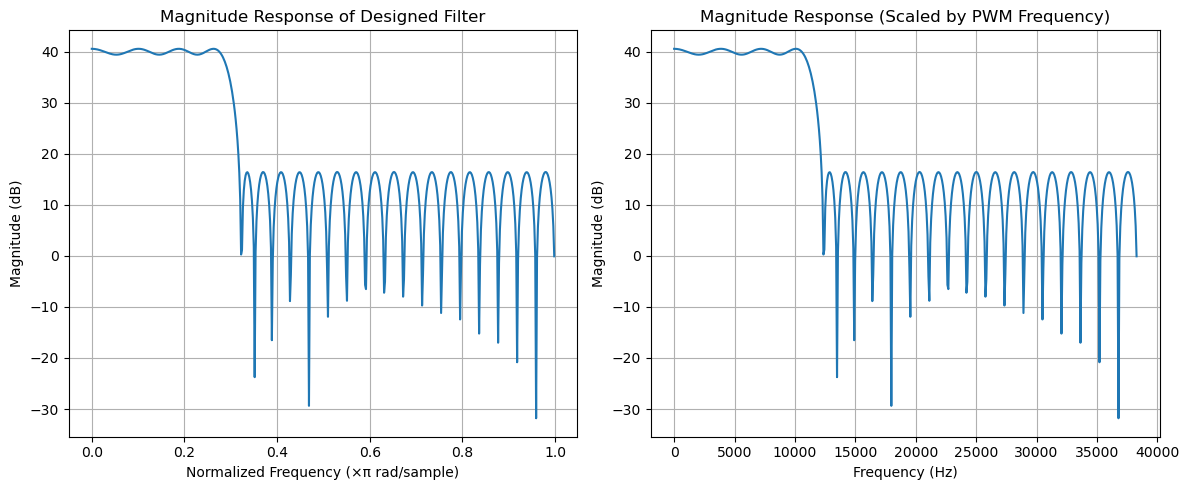

In [29]:
#Here's what your filter looks like graphically

# Frequency response of the filter
w, h = signal.freqz(coef, worN=512)

# Create side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Magnitude Response (Normalized Frequency)
axs[0].plot(w / np.pi, sig2db(np.abs(h)))
axs[0].set_title('Magnitude Response of Designed Filter')
axs[0].set_xlabel('Normalized Frequency (×π rad/sample)')
axs[0].set_ylabel('Magnitude (dB)')
axs[0].grid()

# Plot 2: Magnitude Response (Scaled by PWM Frequency)
axs[1].plot(w * pwm_frequency, sig2db(np.abs(h)))
axs[1].set_title('Magnitude Response (Scaled by PWM Frequency)')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Magnitude (dB)')
axs[1].grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()